<a href="https://colab.research.google.com/github/kavyajeetbora/modern_geospatial_stack/blob/master/use_cases/Location_Intelligence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
!pip install -q osmnx
!pip install -q h3
!pip install -q pydeck
!pip install -q pandana

- Landuse data
- POIs

In [55]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import LineString, Point
import h3
from matplotlib import colormaps
import pydeck as pdk
import pandas as pd
import pandana as pdna

--2024-05-06 10:47:32--  https://github.com/kavyajeetbora/modern_geospatial_stack/raw/master/notebooks/gurgaon.gpkg
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kavyajeetbora/modern_geospatial_stack/master/notebooks/gurgaon.gpkg [following]
--2024-05-06 10:47:33--  https://raw.githubusercontent.com/kavyajeetbora/modern_geospatial_stack/master/notebooks/gurgaon.gpkg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98304 (96K) [application/octet-stream]
Saving to: ‘gurgaon.gpkg’

gurgaon.gpkg        100%[===================>]  96.00K  --.-KB/s    in 0.06s   

2024-05-06 10:47:33 (1.69 MB/s) - 

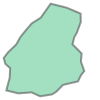

In [56]:
!wget https://github.com/kavyajeetbora/modern_geospatial_stack/raw/master/notebooks/gurgaon.gpkg -O gurgaon.gpkg

aoi = gpd.read_file("gurgaon.gpkg")['geometry'][0]
aoi

[Get OSM features from Polygon](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.features.features_from_polygon)

## Download the OSM Data

Download all the points of interests from OSM with the following tags:
`amenity`, `leisure`, `office`, `shop`, `healthcare`

Here is a comprehensive list of [OSM features](https://wiki.openstreetmap.org/wiki/Map_features)

In [58]:
POIs = ox.features.features_from_polygon(aoi, tags={'amenity':True, 'leisure':True, 'office':True, 'shop':True, 'healthcare':True}).reset_index()
POIs = POIs[POIs['geometry'].type != LineString]
POIs = POIs.to_crs('EPSG:7760')
POIs['geometry'] = POIs['geometry'].centroid
POIs = POIs.to_crs('EPSG:4326')
POIs = POIs[['osmid', 'amenity', 'name', 'geometry']]
POIs['lon'] = POIs.geometry.apply(lambda p: p.x)
POIs['lat'] = POIs.geometry.apply(lambda p: p.y)
print(f'Total points of interests found: {POIs.shape[0]}')
POIs.sample(5)

Total points of interests found: 1930


,osmid,amenity,name,geometry,lon,lat
103,477905016,pub,Machaan,POINT (77.09613 28.49969),77.096133,28.499695
769,10594437383,fast_food,McDonald's,POINT (77.03928 28.41799),77.039276,28.417993
665,8266996107,clinic,DR AKRAM JAWED'S THE UPPER LIMB CLINIC,POINT (77.04356 28.43591),77.043558,28.435908
1102,11718344025,NaN,tree,POINT (77.06275 28.42604),77.062746,28.426038
953,11005317424,bench,NaN,POINT (77.04138 28.45431),77.041383,28.454309


## Spatial Indexing the POIs


Choosing the spatial index resolution:

<img src='https://t1nak.github.io/blog/2020/h3_pics/hex_res2.png' height=300/>

In [40]:
# find hexs containing the points

APERTURE_SIZE = 8
hex_col = 'hex'+str(APERTURE_SIZE)

delhi_gdf = POIs.copy()

delhi_gdf[hex_col] = delhi_gdf.apply(lambda x: h3.geo_to_h3(x.geometry.y,x.geometry.x,APERTURE_SIZE),1)
delhi_gdf.sample(5)

,osmid,amenity,name,geometry,hex8
1621,607223688,NaN,NaN,POINT (77.06137 28.41449),883da11817fffff
1920,1274598060,fuel,NaN,POINT (77.04314 28.40606),883da11803fffff
1252,127237421,NaN,NaN,POINT (77.08770 28.49473),883da111a1fffff
472,6215682700,NaN,Stryker Global Tech Center,POINT (77.04476 28.40595),883da11839fffff
1741,1168785755,NaN,NaN,POINT (77.09465 28.39868),883da118a9fffff


In [41]:
poi_density = delhi_gdf.groupby(hex_col)['geometry'].count().rename('poi_count').reset_index()
poi_density.sample(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,hex8,poi_count
132,883da11adbfffff,19
94,883da11a83fffff,28
117,883da11ab7fffff,5
29,883da11811fffff,26
137,883da11ae7fffff,15


In [42]:
def color_code_value(value, cmap):
    color = cmap(value)
    scaled_colors = list(map(lambda x: int(x*255), color[:3]))
    scaled_alpha = int(color[3]*100)

    scaled_colors += [scaled_alpha]
    return scaled_colors

def colormap_dataframe(df, value_col, cmap):

    xdf = df.copy()

    ## Scale the temperature values between 0-1; using MinMax Scaler
    xdf[f'norm_{value_col}'] = (xdf[value_col]-xdf[value_col].min())/(xdf[value_col].max()-xdf[value_col].min())
    xdf['color'] = xdf[f'norm_{value_col}'].apply(lambda x: color_code_value(x, cmap))
    xdf[['R', 'G', 'B', 'A']] = pd.DataFrame(xdf['color'].to_list())
    xdf = xdf.drop(['color', f'norm_{value_col}'], axis=1)

    ## formatting the temperature value upto 1 decimal place
    xdf[value_col] = xdf[value_col].round(1)

    return xdf

def create_h3_hex_layer(df):

    # Define a layer to display on a map
    layer = pdk.Layer(
        "H3HexagonLayer",
        df,
        pickable=True,
        stroked=True,
        filled=True,
        extruded=False,
        get_hexagon=hex_col,
        get_fill_color="[R, G, B, A]"
    )

    return layer

tooltip = {
        "html": "Amenities Count: {poi_count}",
        "style": {
            "backgroundColor": "#4CAF50",   # Green shade for background
            "color": "#FFFFFF",             # White for text color
            "border": "2px solid #4CAF50",  # Matching border color
            "borderRadius": "5px",          # Rounded corners
            "boxShadow": "2px 2px 10px rgba(0, 0, 0, 0.2)"  # Soft shadow effect
        }
    }

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


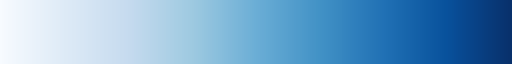

In [43]:
## Choose a colormap
cmap = colormaps['Blues']
cmap

In [44]:
## Apply the colormap to the dataframe
xdf = colormap_dataframe(df=poi_density, value_col='poi_count', cmap=cmap)

## Now create a H3HexagonLayer
layer = create_h3_hex_layer(xdf)

# Set the viewport location
x,y = aoi.centroid.x, aoi.centroid.y
view_state = pdk.ViewState(latitude=y, longitude=x, zoom=11, bearing=0, pitch=30)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip=tooltip)
r

<IPython.core.display.Javascript object>

{
  "initialViewState": {
    "bearing": 0,
    "latitude": 28.437398083125167,
    "longitude": 77.06463665845695,
    "pitch": 30,
    "zoom": 11
  },
  "layers": [
    {
      "@@type": "H3HexagonLayer",
      "data": [
        {
          "A": 100,
          "B": 250,
          "G": 241,
          "R": 232,
          "hex8": "883da10341fffff",
          "poi_count": 7
        },
        {
          "A": 100,
          "B": 252,
          "G": 246,
          "R": 239,
          "hex8": "883da10345fffff",
          "poi_count": 4
        },
        {
          "A": 100,
          "B": 246,
          "G": 233,
          "R": 220,
          "hex8": "883da10349fffff",
          "poi_count": 12
        },
        {
          "A": 100,
          "B": 251,
          "G": 244,
          "R": 237,
          "hex8": "883da1034bfffff",
          "poi_count": 5
        },
        {
          "A": 100,
          "B": 253,
          "G": 247,
          "R": 242,
          "hex8": "883da1034dfffff",
          "poi_count": 3
        },
        {
          "A": 100,
          "B": 251,
          "G": 244,
          "R": 237,
          "hex8": "883da10361fffff",
          "poi_count": 5
        },
        {
          "A": 100,
          "B": 249,
          "G": 240,
          "R": 230,
          "hex8": "883da10365fffff",
          "poi_count": 8
        },
        {
          "A": 100,
          "B": 251,
          "G": 243,
          "R": 235,
          "hex8": "883da10369fffff",
          "poi_count": 6
        },
        {
          "A": 100,
          "B": 248,
          "G": 238,
          "R": 228,
          "hex8": "883da1036dfffff",
          "poi_count": 9
        },
        {
          "A": 100,
          "B": 254,
          "G": 249,
          "R": 244,
          "hex8": "883da11185fffff",
          "poi_count": 2
        },
        {
          "A": 100,
          "B": 255,
          "G": 251,
          "R": 247,
          "hex8": "883da11187fffff",
          "poi_count": 1
        },
        {
          "A": 100,
          "B": 172,
          "G": 102,
          "R": 24,
          "hex8": "883da111a1fffff",
          "poi_count": 66
        },
        {
          "A": 100,
          "B": 240,
          "G": 222,
          "R": 203,
          "hex8": "883da111a3fffff",
          "poi_count": 19
        },
        {
          "A": 100,
          "B": 240,
          "G": 222,
          "R": 203,
          "hex8": "883da111a5fffff",
          "poi_count": 19
        },
        {
          "A": 100,
          "B": 244,
          "G": 230,
          "R": 215,
          "hex8": "883da111a7fffff",
          "poi_count": 14
        },
        {
          "A": 100,
          "B": 252,
          "G": 246,
          "R": 239,
          "hex8": "883da111a9fffff",
          "poi_count": 4
        },
        {
          "A": 100,
          "B": 238,
          "G": 218,
          "R": 196,
          "hex8": "883da111abfffff",
          "poi_count": 22
        },
        {
          "A": 100,
          "B": 248,
          "G": 238,
          "R": 228,
          "hex8": "883da111adfffff",
          "poi_count": 9
        },
        {
          "A": 100,
          "B": 249,
          "G": 240,
          "R": 230,
          "hex8": "883da111b5fffff",
          "poi_count": 8
        },
        {
          "A": 100,
          "B": 255,
          "G": 251,
          "R": 247,
          "hex8": "883da111b7fffff",
          "poi_count": 1
        },
        {
          "A": 100,
          "B": 255,
          "G": 251,
          "R": 247,
          "hex8": "883da111bdfffff",
          "poi_count": 1
        },
        {
          "A": 100,
          "B": 240,
          "G": 221,
          "R": 201,
          "hex8": "883da111e5fffff",
          "poi_count": 20
        },
        {
          "A": 100,
          "B": 252,
          "G": 246,
          "R": 239,
          "hex8": "883da111e7fffff",
          "poi_count": 4
        },
        {
          "A

## Accessibility

Get the network graph for the AOI

In [51]:
G = ox.graph_from_polygon(aoi)

## Convert it to GDFs
nodes, edges = ox.convert.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)
edges = edges.reset_index()

Create a `pandana` network from the given graph

In [57]:
network = pdna.Network(nodes["x"], nodes["y"], edges["u"], edges["v"],edges[["length"]])

## Extracting the transportation features from OSM

Total Number of features: 1010


<Axes: >

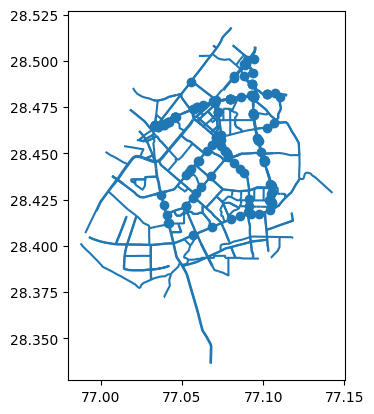

In [160]:
# xx = ox.features.features_from_polygon(aoi, tags={'healthcare':True, 'amenity':['clinic', 'doctors', 'hospital', 'dentist', 'pharmacy']})
tags={'public_transport': True, 'highway': ['primary', 'secondary', 'tertiary']}
xx = ox.features.features_from_polygon(aoi, tags=tags)
print(f'Total Number of features: {xx.shape[0]}')
xx.plot()

In [161]:
mobility = ox.features.features_from_polygon(aoi, tags=tags).reset_index()
mobility = mobility.to_crs('EPSG:7760')  ## Converting the geometries to UTM for distance calculation
mobility['geometry'] = mobility['geometry'].centroid
mobility = mobility.to_crs('EPSG:4326') ## Converting back to WGS84 for visualization
mobility = mobility[['osmid', 'public_transport','name', 'geometry']]
mobility['lon'] = mobility.geometry.apply(lambda p: p.x)
mobility['lat'] = mobility.geometry.apply(lambda p: p.y)
print(f'Total points of interests found: {mobility.shape[0]}')
mobility.sample(5)

Total points of interests found: 1010


,osmid,public_transport,name,geometry,lon,lat
920,1156857830,NaN,Saheed Ripon Katyal Marg,POINT (77.05589 28.48915),77.055895,28.489146
314,188137551,NaN,NaN,POINT (77.06051 28.46855),77.060511,28.468551
15,2533456421,stop_position,Moulsari Avenue Station,POINT (77.09463 28.50078),77.094631,28.500778
135,11633746976,platform,NaN,POINT (77.08020 28.41447),77.080198,28.414470
937,1183652662,NaN,NaN,POINT (77.09705 28.42115),77.097054,28.421152


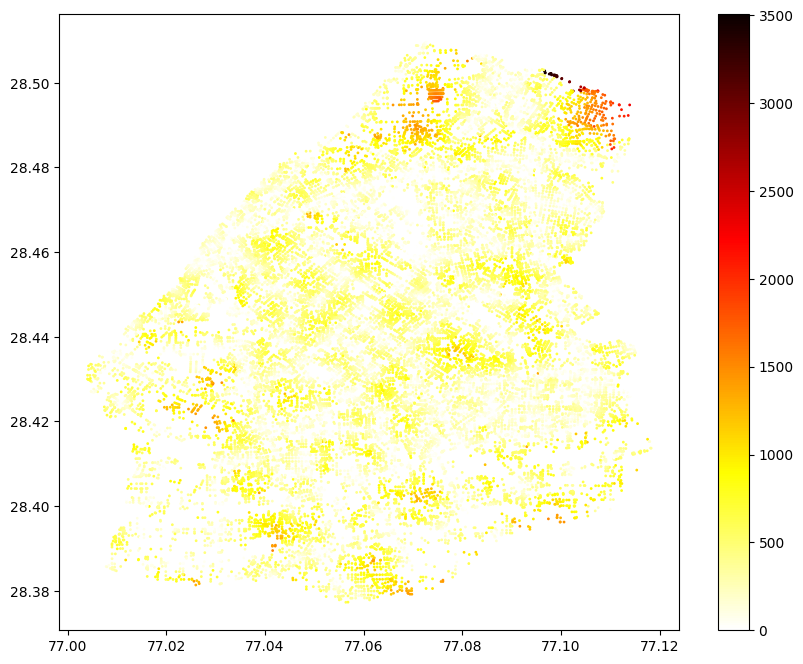

In [162]:
# initialize each amenity category with the locations (lon/lat coordinates)

max_distance=25000 ## in meters
num_pois = 1

category = 'all'
network.set_pois(category=category, maxdist = max_distance, maxitems=num_pois, x_col=mobility['lon'], y_col=mobility['lat'])
accessibility = network.nearest_pois(distance = max_distance, category=category, num_pois=num_pois)

def plot_nearest_amenity(accessibility,n):
    fig, ax = network.plot(accessibility[n]);
    ax.set_facecolor('k');
    ax.set_title('Pedestrian accessibility in Gurgaon (distance to pois, in meters (n = {}))'.format(category,n), fontsize=14);
    return fig

fig = plot_nearest_amenity(accessibility,num_pois)

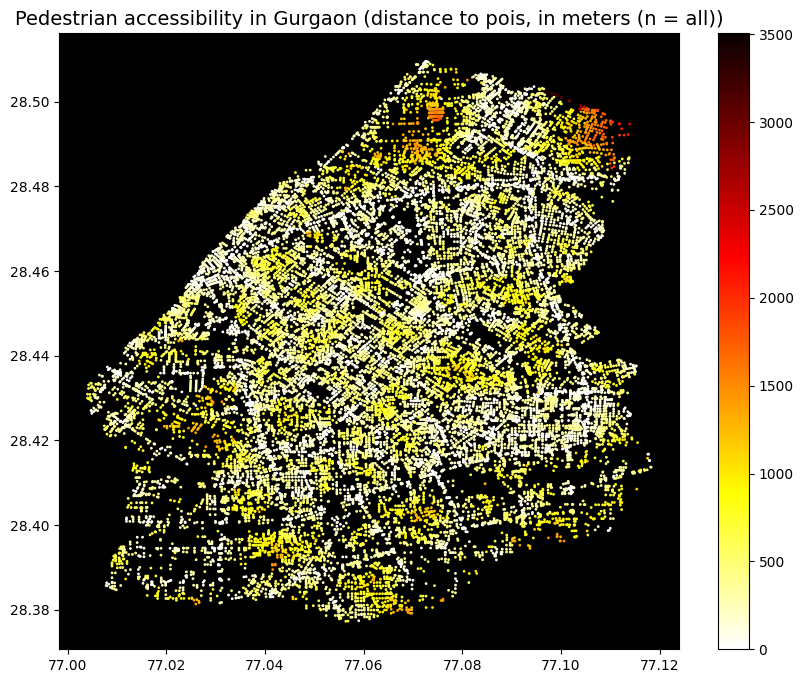

In [163]:
fig

## Converting the points to h3 spaital index

In [164]:
pedestrian_mins = accessibility.copy()

## Convert the accessibility to minutes taken to walk to the POI
walking_speed = 100 ## m/min
pedestrian_mins = pedestrian_mins/walking_speed

pedestrian_mins = nodes.join(pedestrian_mins)[['geometry', 1]].rename(columns={1:'time_min'})
pedestrian_mins[hex_col] = pedestrian_mins.apply(lambda p: h3.geo_to_h3(p.geometry.y,p.geometry.x,APERTURE_SIZE),1)
pedestrian_mins.sample(5)

,geometry,time_min,hex8
osmid,,,
9714476430,POINT (77.03675 28.42874),0.30528,883da11851fffff
11539830251,POINT (77.06434 28.50043),3.18641,883da111e5fffff
11011922742,POINT (77.04137 28.45033),2.12124,883da11ae1fffff
4140312369,POINT (77.01274 28.38948),2.76712,883da11867fffff
11518577205,POINT (77.06225 28.41768),2.62294,883da11813fffff


Aggregate the results per h3 hexagon

In [165]:
agg_ped_mins = pedestrian_mins[[hex_col, 'time_min']].groupby(hex_col).mean().reset_index()
agg_ped_mins.sample(5)

,hex8,time_min
73,883da11883fffff,4.486466
57,883da11847fffff,5.376619
38,883da11819fffff,3.931263
168,883da11ae3fffff,4.716138
43,883da11825fffff,9.536534


In [170]:
## Apply the colormap to the dataframe
cmap = colormaps['PRGn']
xdf = colormap_dataframe(df=agg_ped_mins, value_col='time_min', cmap=cmap)

## Now create a H3HexagonLayer
layer = create_h3_hex_layer(xdf)

# Set the viewport location
x,y = aoi.centroid.x, aoi.centroid.y
view_state = pdk.ViewState(latitude=y, longitude=x, zoom=11, bearing=0, pitch=30)


tooltip = {
        "html": "Pedestrian Accessibility: {time_min} mins",
        "style": {
            "backgroundColor": "#4CAF50",   # Green shade for background
            "color": "#FFFFFF",             # White for text color
            "border": "2px solid #4CAF50",  # Matching border color
            "borderRadius": "5px",          # Rounded corners
            "boxShadow": "2px 2px 10px rgba(0, 0, 0, 0.2)"  # Soft shadow effect
        }
    }

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip=tooltip)
r

<IPython.core.display.Javascript object>

{
  "initialViewState": {
    "bearing": 0,
    "latitude": 28.437398083125167,
    "longitude": 77.06463665845695,
    "pitch": 30,
    "zoom": 11
  },
  "layers": [
    {
      "@@type": "H3HexagonLayer",
      "data": [
        {
          "A": 100,
          "B": 123,
          "G": 36,
          "R": 110,
          "hex8": "883da10341fffff",
          "time_min": 2.8
        },
        {
          "A": 100,
          "B": 112,
          "G": 28,
          "R": 100,
          "hex8": "883da10345fffff",
          "time_min": 2.4
        },
        {
          "A": 100,
          "B": 212,
          "G": 175,
          "R": 201,
          "hex8": "883da10349fffff",
          "time_min": 7.9
        },
        {
          "A": 100,
          "B": 233,
          "G": 216,
          "R": 232,
          "hex8": "883da1034bfffff",
          "time_min": 10.0
        },
        {
          "A": 100,
          "B": 134,
          "G": 48,
          "R": 121,
          "hex8": "883da1034dfffff",
          "time_min": 3.3
        },
        {
          "A": 100,
          "B": 189,
          "G": 139,
          "R": 173,
          "hex8": "883da10361fffff",
          "time_min": 6.4
        },
        {
          "A": 100,
          "B": 101,
          "G": 19,
          "R": 89,
          "hex8": "883da10365fffff",
          "time_min": 1.9
        },
        {
          "A": 100,
          "B": 152,
          "G": 79,
          "R": 136,
          "hex8": "883da10369fffff",
          "time_min": 4.2
        },
        {
          "A": 100,
          "B": 75,
          "G": 0,
          "R": 64,
          "hex8": "883da1036bfffff",
          "time_min": 0.8
        },
        {
          "A": 100,
          "B": 155,
          "G": 84,
          "R": 139,
          "hex8": "883da1036dfffff",
          "time_min": 4.5
        },
        {
          "A": 100,
          "B": 90,
          "G": 11,
          "R": 78,
          "hex8": "883da11137fffff",
          "time_min": 1.5
        },
        {
          "A": 100,
          "B": 96,
          "G": 16,
          "R": 85,
          "hex8": "883da11185fffff",
          "time_min": 1.7
        },
        {
          "A": 100,
          "B": 114,
          "G": 29,
          "R": 102,
          "hex8": "883da111a1fffff",
          "time_min": 2.5
        },
        {
          "A": 100,
          "B": 202,
          "G": 157,
          "R": 188,
          "hex8": "883da111a3fffff",
          "time_min": 7.2
        },
        {
          "A": 100,
          "B": 167,
          "G": 106,
          "R": 150,
          "hex8": "883da111a5fffff",
          "time_min": 5.2
        },
        {
          "A": 100,
          "B": 127,
          "G": 39,
          "R": 114,
          "hex8": "883da111a7fffff",
          "time_min": 3.0
        },
        {
          "A": 100,
          "B": 123,
          "G": 36,
          "R": 110,
          "hex8": "883da111a9fffff",
          "time_min": 2.8
        },
        {
          "A": 100,
          "B": 145,
          "G": 68,
          "R": 131,
          "hex8": "883da111abfffff",
          "time_min": 3.9
        },
        {
          "A": 100,
          "B": 145,
          "G": 68,
          "R": 131,
          "hex8": "883da111adfffff",
          "time_min": 3.9
        },
        {
          "A": 100,
          "B": 169,
          "G": 222,
          "R": 175,
          "hex8": "883da111b5fffff",
          "time_min": 16.0
        },
        {
          "A": 100,
          "B": 27,
          "G": 68,
          "R": 0,
          "hex8": "883da111b7fffff",
          "time_min": 23.0
        },
        {
          "A": 100,
          "B": 109,
          "G": 182,
          "R": 104,
          "hex8": "883da111bdfffff",
          "time_min": 18.1
        },
        {
          "A": 100,
          "B": 144,
          "G": 65,
          "R": 129,
          "hex8": "883da111e1fffff",
          "time_min": 3.9
        },
        {
          "A": 100